In [2]:
#Loaded Libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
install.packages("expss")
library(expss)
library(ggplot2)
library(GGally)
library("gridExtra")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [6]:
# Data Loaded 

cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", 
                                         "sex", 
                                         "cp", 
                                         "trestbps", 
                                         "chol", 
                                         "fbs", 
                                         "restercg", 
                                         "thalach", 
                                         "exang", 
                                         "oldpeak", 
                                         "slope", 
                                         "ca", 
                                         "thal", 
                                         "num"))
cleveland_data$num <- as.factor(cleveland_data$num)
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restercg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [7]:
# see if there is other number rather than 0-4 in the num column
cleveland_data  %>%
    select(num)  %>% 
    unlist() %>% 
    levels()

# transform num from 0-4 to 0 or 1 (1, 2, 3, 4) and store into diagnosis variable
cleveland_data <- cleveland_data %>%
                  mutate(diagnosis = dplyr::recode(num, '0' = 'absent', .default = 'present'))

head(cleveland_data)

# to see how the original data distribute
cleveland_data %>% 
    group_by(diagnosis) %>%
    summarize(n = n())

# We select all the numerical columns and diagnosis column
cleveland_data2 <- cleveland_data%>%
            select(age, trestbps, chol, thalach, oldpeak, diagnosis)
head(cleveland_data2)

heart_tidy <- cleveland_data2

# Above codes are from the proposal, with the tidy dataset cleveland_data2 renamed as heart_tidy

[1] "0" "1" "2" "3" "4"

age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,present
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,present
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,absent


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
absent,164
present,139


age,trestbps,chol,thalach,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,absent
67,160,286,108,1.5,present
67,120,229,129,2.6,present
37,130,250,187,3.5,absent
41,130,204,172,1.4,absent
56,120,236,178,0.8,absent


[1] 17

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7733333
kap,binary,0.5321101


          Truth
Prediction absent present
   absent      37      13
   present      4      21

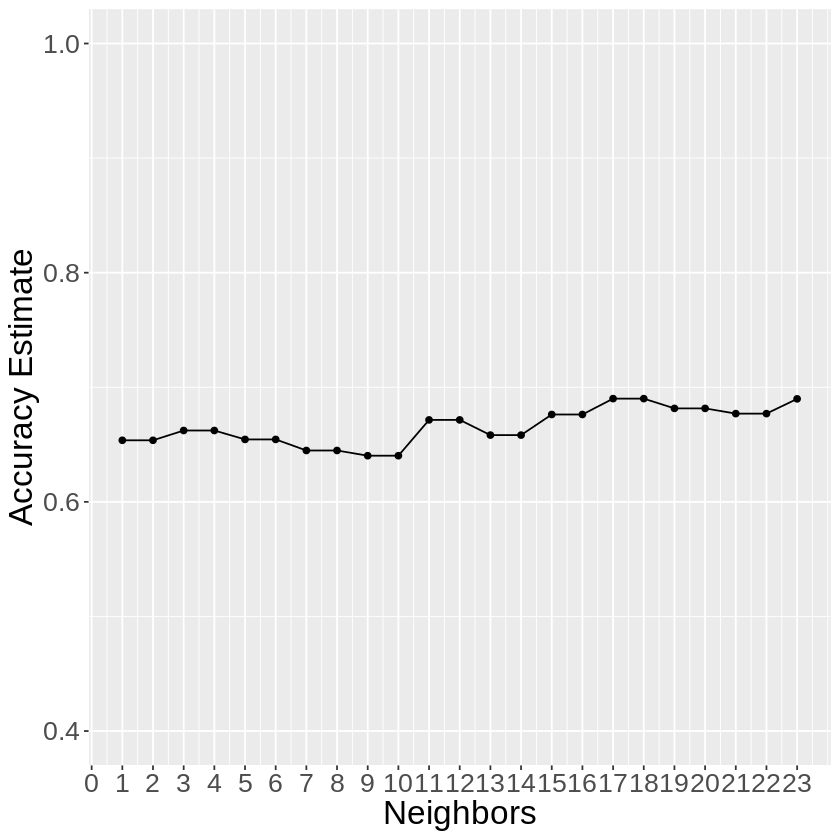

In [8]:
# We will use KNN Classification with 10 folds cross-validation for choosing the appropriate k value. The resulting accuracy will be calculated

# Splitting the data to training and testing data

heart_split <- initial_split(heart_tidy, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# Perform 10 folds Cross-Validation for heart_train dataset to choose appropriate k
set.seed(2022)

heart_10fold <- vfold_cv(heart_train, v=10, strata = diagnosis)

set.seed(2022)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")
#graph of different accuracy
knn_recipe <- recipe(diagnosis ~ chol + thalach + oldpeak, data = heart_train) %>% # Important !!!!!!!!!!!! Using only 3 predictors (chol,thalach, oldpeak) will gain the max accuracy
            step_center(all_predictors()) %>%
            step_scale(all_predictors())

heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)

gridvals <- tibble(neighbors = seq(from = 1, to = 23))

heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 

accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 


accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 23, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) +# adjusting the y-axis 
       theme(text=element_text(size=20))

accuracy_versus_k

appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()
appropriate_k

set.seed(2022)
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)

heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)

heart_metrics <- heart_predictions %>% 
    metrics(truth = diagnosis, estimate = .pred_class)

heart_conf_mat <- heart_predictions %>%
    conf_mat(truth =diagnosis, estimate = .pred_class)

heart_metrics
heart_conf_mat